In [6]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from datasets import load_dataset

In [7]:
dataset = load_dataset("conll2003")

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [8]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [9]:
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [18]:
labels = dataset['train'].features['ner_tags'].feature.names

In [19]:
labels

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [20]:
tokenized_labels = {label: i for i, label in enumerate(labels)}

In [21]:
tokenized_labels

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [33]:
# We need to tokenize each word in the sentence with its corresponding label
training_data = {"tokens": [], "labels": []}
def map_word_label(data):
    for i in range(len(data)):
        tokens = data[i]['tokens']
        labels = data[i]['ner_tags']
        for i in range(len(tokens)):
            if tokens[i] in training_data['tokens']:
                continue
            else:
                training_data['tokens'].append(tokens[i])
                training_data['labels'].append(labels[i])

map_word_label(dataset['train'])


In [34]:
import pandas as pd

df = pd.DataFrame(training_data)

In [35]:
df

,tokens,labels
0,EU,3
1,rejects,0
2,German,7
3,call,0
4,to,0
...,...,...
23618,216,0
23619,217,0
23620,Swe,5
23621,Bradley,1


In [38]:
df['tokens'].nunique()

23623

In [46]:
df[df['labels'] == 3]['labels'].count().item()

1443

In [44]:
# label to count graph
label_counts = [df[df['labels'] == i]['labels'].count().item() for i in range(9)]

In [53]:
data = {}
idx = 0
for key in tokenized_labels.keys():
    data[key] = label_counts[idx]
    idx+=1

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

data

{'O': 15529,
 'B-PER': 1627,
 'I-PER': 2213,
 'B-ORG': 1443,
 'I-ORG': 819,
 'B-LOC': 1050,
 'I-LOC': 189,
 'B-MISC': 565,
 'I-MISC': 188}

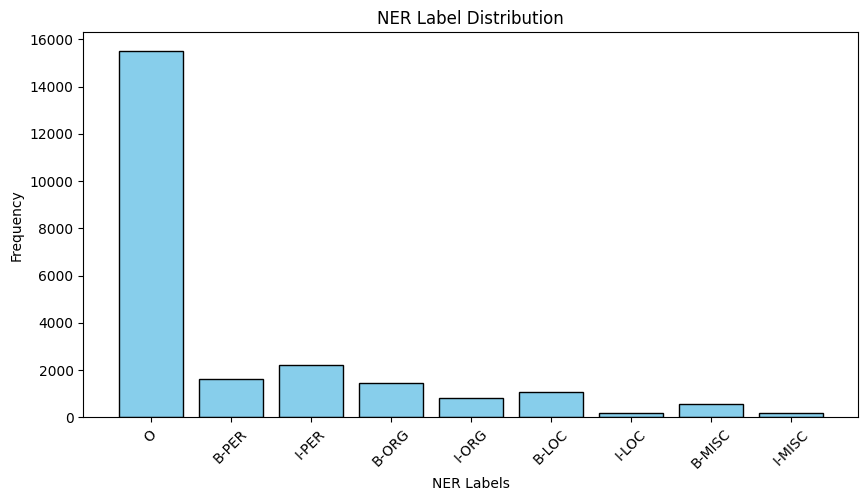

In [56]:
labels = list(data.keys())
values = list(data.values())

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue', edgecolor='black')

# Labels & title
plt.xlabel("NER Labels")
plt.ylabel("Frequency")
plt.title("NER Label Distribution")
plt.xticks(rotation=45)  # Rotate labels for better visibility

# Show plot
plt.show()
